# Sequence Processing with Recurrent Neural Networks

## Background

So far, we have seen how word vectors can be constructed from corpus statistics, and how they can be utilized to infer latent semantic content either in isolation (e.g. genders from names) or in relation to one another (e.g. similarities and analogies).

For tasks involving larger linguistic units such as phrases, sentences and dialogues, we need machinery capable of processing _sequences_ or _structures_ of words.

Recurrent Neural Networks are an example of such machinery; for this assignment, you will construct a recurrent neural network that annotates each word of a sentence with a linguistically informative marker. In the simple case (and in this assignment), these markers will be POS tags. However, they can also be other kinds of tags, e.g. more fine-grained morphosyntactic [categories](https://en.wikipedia.org/wiki/Combinatory_categorial_grammar) (supertags).

This task is a case of sequence labeling.  A good reference point is Jurafsky and Martin [Chapter 9](https://web.stanford.edu/~jurafsky/slp3/9.pdf). For a fuller view of the picture, a good reference point is Alex Graves' [dissertation](https://www.cs.toronto.edu/~graves/preprint.pdf).

We will take a gradual approach, first inspecting recurrent neural networks, then moving on to data processing using high-grade word vectors before finally moving to the problem at hand.

---

There are 9 tasks in this assignment for a total of 8 points. Each task comes with its points. Note that some tasks have 0 points. Some of such tasks are optional but useful to solve. Some of them are mandatory but trivial in the sense that you need to slightly adjust existing code.

---

You are greatly encouraged to add comments to your code describing what particular lines of code do (in general, a great habit to have in your coding life).
Additionally please follow these rules when submitting the notebook:

* Put all code in the cell with the `# YOUR CODE HERE` comment or `NotImplemented`.
* For theoretical questions, put your solution in the `YOUR ANSWER HERE` cell and keep the header(!).
* Don't change or delete any initially provided cells, either text or code, unless explicitly instructed to do so.
* Don't delete the comment lines `# TEST...` or edit their code cells. The test cells are for sanity checking. Passing them doesn't necessarily mean that your code is fine.
* Don't change the names of provided functions and variables or arguments of the functions.
* Don't clear the output of your code cells.
* Don't output unnecessary info (e.g., printing variables for debugging purposes). This clutters the notebook and slows down the grading. You can have print() in the code, but comment them out before submitting the notebook.
* Delete those cells that you inserted for your own debugging/testing purposes.
* Don't forget to fill in the contribution information.
* Test your code and **make sure we can run your notebook** in the colab environment.
* A single notebook file (without archiving) per group should be submitted via BB.

<font color="red">Following these rules helps us to grade the submissions relatively efficiently. If these rules are violated, a submission will be subject to penalty points.</font>

# <font color="red">Contributions</font>

~~Delete this text and write instead of it your:~~
* Antreas Alexandrou,Sotiris Zenios
* All subsections where completed in pair-programming sessions together in order to better understand all the material

## Recurrent Neural Networks
Recurrent Neural Networks are a particularly interesting class of neural networks. Unlike standard fully-connected networks that accept a fixed-size input and produce a fixed-size output over a predefined number of computational steps (i.e. network layers), RNNs instead operate on sequences of vectors.

Computationally, feedforward networks may be seen as a trainable (but parametrically fixed) function, whereas RNNs act as continuous, stateful programs operating on sequences of inputs.
Cognitively, this may be viewed as enhancing our system's perceptive and computational abilities with a notion of memory.
In the general case, this statefulness is captured by an intermediate hidden vector which is adjusted throughout the computation, affected by both the immediately previous version of itself __and__ the current input.

RNNs are nowadays established as the core machinery of neural sequence processing.

A simple recurrent network (SRN or Elman network) is described by the equations:
* $h_t = \theta_h (W_h x_t + U_h h_{t-1} + b_h ) $
* $y_t = \theta_y (W_y h_t + b_y) $

where (at timestep $t$) $x_t$, $h_t$, $y_t$ are the network's input, hidden and output representations respectively, $\theta_h$, $\theta_y$ are its hidden and output activation functions, and $W_h$, $U_h$, $b_h$, $W_y$, $b_y$ are the parametric tensors to be learned.

In [ ]:
import numpy as np
import torch
print(f"torch ver={torch.__version__}\nnumpy ver={np.__version__}")
from torch import FloatTensor, LongTensor
from typing import Tuple, List, Callable, Optional
torch.set_printoptions(precision=8) #to increase precision of printing floats

torch ver=2.1.0+cu118
numpy ver=1.23.5


We will use the following function to concisely convert torch tensors to numpy arrays before printing tensors.

In [ ]:
def tr2np(tensor):
    """Convert torch tensor into numpy array"""
    return tensor.detach().numpy()

### Our own SRN
Let's make our own simple recurrent network from scratch, to get an idea of its inner workings. To make our life just a bit simpler, we will use `torch.nn.Linear` to model the internal transformations.

Complete the `mySRN` class, which is initialized with the input $d_i$, hidden $d_h$ and output $d_o$ dimensionalities, as well as two non-linear functions $\theta_h$ and $\theta_y$, and constructs an SRN implementing three `torch.nn.Linear` layers:
1. `x_to_h`: a layer that takes $x_t$ and produces $W_h x_t$
2. `h_to_h`: a layer that takes $h_{t-1}$ and produces $U_h h_{t-1} + b_h$
3. `h_to_y`: a layer that takes $h_t$ and produces $W_y h_t + b_y$

Implement the function `step` that performs a computational step, accepting $x_t$ and $h_{t-1}$ and producing $h_t$ and $y_t$.

Implement the function `forward` that accepts a List of inputs $X$, an initial hidden vector $h_{-1}$ and iteratively applies `step` until the input sequence is exhausted, returning a List of outputs $Y$ (of the same length as $X$).

<font color="red">_Hint_: Note that `x_to_h` does not have a bias term $b$, since we will incorporate it into `h_to_h`

In [ ]:
# @title c1 [.5pt]

class mySRN(torch.nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        hidden_activation: Callable[[FloatTensor], FloatTensor],
        output_activation: Callable[[FloatTensor], FloatTensor],
        device: str = 'cpu'
    ) -> None:
        super().__init__()
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.device = device
        #
        self.x_to_h = torch.nn.Linear(input_dim, hidden_dim, bias=False)
        self.h_to_h = torch.nn.Linear(hidden_dim, hidden_dim)
        self.h_to_y = torch.nn.Linear(hidden_dim, output_dim)
    def step(self, x: FloatTensor, h: FloatTensor) -> Tuple[FloatTensor, FloatTensor]:
        # YOUR CODE HERE
        h_new = self.hidden_activation(self.x_to_h(x) + self.h_to_h(h))
        y = self.output_activation(self.h_to_y(h_new))
        return h_new, y

    def forward(self, X: List[FloatTensor], h: FloatTensor) -> List[FloatTensor]:
        # detach elements of the Y lsit before returning
        Y = []
        # YOUR CODE HERE
        for x in X:
            h, y = self.step(x, h)
            Y.append(y.detach())
        return Y

The following toy RNN helps you to verify whether your implementation is correct.  
Use the numbers below in the functions, and you can manually verify the output of the RNN.  
This manual check will help you to see whether you are understanding the calculations behind the RNN.

In [ ]:
# TEST c1
# let's use seed so that the weights are initialized in a deterministic way
torch.manual_seed(10)
# create our RNN with some short dimensions
my_rnn = mySRN(3, 2, 1, torch.nn.ReLU(), torch.nn.ReLU(), 'cpu')

# printing initilized weights and biases
print("X->H", "\nmatrix:\n", tr2np(my_rnn.x_to_h.weight), "\nbias:", my_rnn.x_to_h.bias)
print("H->H", "\nmatrix:\n", tr2np(my_rnn.h_to_h.weight), "\nbias:", tr2np(my_rnn.h_to_h.bias))
print("H->Y", "\nmatrix:\n", tr2np(my_rnn.h_to_y.weight), "\nbias:", tr2np(my_rnn.h_to_y.bias))

# running the RNN on a sample input of size 2 and an initial hidden vector
output = my_rnn.forward([FloatTensor([0,0,1]), FloatTensor([1,0,0])],
                         FloatTensor([1,1]))

print("output:\n", output)

X->H 
matrix:
 [[-0.04839968 -0.01979553 -0.21650827]
 [ 0.13281555 -0.33030522 -0.10181434]] 
bias: None
H->H 
matrix:
 [[ 0.27406603  0.6637026 ]
 [ 0.16658802 -0.23989876]] 
bias: [ 0.06780045 -0.07924712]
H->Y 
matrix:
 [[0.28863114 0.0809646 ]] 
bias: [0.2769911]
output:
 [tensor([0.50473863]), tensor([0.35998842])]


In practice, we do not need to write our own functions for common RNN architectures.
Torch already provides the [necessary abstractions](https://pytorch.org/docs/stable/nn.html#recurrent-layers).

The [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) wrapper implements highly optimized forward routines to compute the hidden representations of a full input sequence.

Some pointers:
* Unlike our naive implementation, RNN accepts a 3-dimensional tensor of shape (seq_len, batch_shape, input_dim) rather than a list of 2-dimensional tensors
* If no initial hidden state is provided, it defaults to a zero tensor
* The class produces just the RNN hidden states; it is up to us to define the `h_to_y` transformation on top of them
* The non-linearity argument is a string; our only two choices are either `"tanh"` or `"relu"` (shorthands for `torch.nn.Tanh` and `torch.nn.ReLU` respectively)

**Read the documentation (!) for further details.**

A brief example is given below.

In [ ]:
rnn = torch.nn.RNN(input_size=16, hidden_size=48, nonlinearity="tanh")
X = torch.rand(10, 32, 16)
h, _ = rnn(X)
print(h.shape)

torch.Size([10, 32, 48])


So, for a random input tensor of shape (seq_len, batch_size, input_dim), we get back an output tensor of shape (seq_len, batch_size, hidden_dim)

In [ ]:
del mySRN, rnn, X, h, my_rnn, output

### A faster version of the SRN
Now let's wrap an `RNN` into a custom module `fastSRN` that implements it along with the `h_to_y` transformation.

In [ ]:
# @title c2 [.5pt]
class fastSRN(torch.nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        hidden_activation: str,
        output_activation: Callable[[FloatTensor], FloatTensor],
        device: str
    ) -> None:
        # YOUR CODE HERE
        super().__init__()

        # RNN layer
        self.rnn = torch.nn.RNN(input_size=input_dim,hidden_size=hidden_dim,nonlinearity=hidden_activation)

        # h_to_y transformation
        self.h_to_y = torch.nn.Linear(hidden_dim, output_dim)
        self.output_activation = output_activation

        self.to(device)

    def forward(self, X:FloatTensor, h: Optional[FloatTensor]=None) -> FloatTensor:
        # YOUR CODE HERE
         # Pass input through RNN
        h_states, _ = self.rnn(X, h)

        # Transform the hidden states to output
        output = self.output_activation(self.h_to_y(h_states))

        return output

Let's see our new implementation in action.

Initialize a random input tensor $X$ that would correspond to 32 sequences,  each of length 10, with each item having 16 features, and a `fastSRN` fit to process it, producing 42-dimensional hidden states and 2-dimensional output vectors for each sequence item.

Run the SRN on the tensor and make sure the output shape is as expected.

In [ ]:
# TEST c2a
fast_srn = fastSRN(
    input_dim=16, hidden_dim=42, output_dim=2,
    hidden_activation="tanh", output_activation=torch.nn.Softmax(dim=-1), device="cpu"
)
X = torch.rand(10, 32, 16)
y = fast_srn(X)
y.shape

torch.Size([10, 32, 2])

Again you can verify correctness of your implementation here, and as before, check whether it really does the computations what equations are describing.

In [ ]:
# TEST c2b
torch.manual_seed(10)
# create our RNN with some short dimensions
fast_srn = fastSRN(3, 2, 2, 'relu', output_activation=torch.nn.Softmax(dim=-1), device='cpu')

# printing initilized weights and biases
print("X->H", "\nmatrix:\n", tr2np(fast_srn.rnn.weight_ih_l0), "\nbias:",  tr2np(fast_srn.rnn.bias_ih_l0))
print("H->H", "\nmatrix:\n", tr2np(fast_srn.rnn.weight_hh_l0), "\nbias:", tr2np(fast_srn.rnn.bias_hh_l0))
print("H->Y", "\nmatrix:\n", tr2np(fast_srn.h_to_y.weight), "\nbias:", tr2np(fast_srn.h_to_y.bias))


# running the RNN on a sample input of size 2
output = fast_srn.forward(torch.FloatTensor([[[0,0,1]], [[1,0,0]]]))

print("output:\n", tr2np(output))

X->H 
matrix:
 [[-0.05927727 -0.02424447 -0.2651674 ]
 [ 0.16266517 -0.40453961 -0.12469659]] 
bias: [ 0.06780045 -0.07924712]
H->H 
matrix:
 [[ 0.27406603  0.6637026 ]
 [ 0.16658802 -0.23989876]] 
bias: [0.28863114 0.0809646 ]
H->Y 
matrix:
 [[ 0.2769911   0.6857927 ]
 [-0.29362798 -0.02499055]] 
bias: [ 0.16262412 -0.00461879]
output:
 [[[0.55461127 0.44538873]]

 [[0.61744654 0.3825534 ]]]


In [ ]:
del fast_srn, X, y, output

You may have noticed a minor complication: in order to utilize batching, we need our input sequences to be of the same length.

This, however, is very rarely the case in practice. A common trick against this problem is _padding_; that is, appending zero tensors to all input sequences shorter than the maximum in-batch length to make them all equally long.

As usual, torch already does the hard work for us via [pad_sequence](https://pytorch.org/docs/stable/nn.html?highlight=pad%20_sequence#torch.nn.utils.rnn.pad_sequence). Given a list of $N$ 2-dimensional tensors, each of shape (seq\_len$_n$, input_dim), it will construct a 3-d tensor of shape ($max_{n \in N}${seq\_len$_n$}, N, input_dim).

An example:

In [ ]:
x1 = torch.rand(1, 3)  # a sequence of 1, 3-dimensional item
x2 = torch.rand(4, 3)  # a sequence of 4, 3-dimensional items
x3 = torch.rand(2, 3)  # a sequence of 2, 3-dimensional items

X = torch.nn.utils.rnn.pad_sequence([x1, x2, x3])

# Can you guess what the shape of X is?
print(X.shape)

torch.Size([4, 3, 3])


Now compare the contents for better understanding.

In [ ]:
for i in [x1, x2, x3]: print(i)
print(f"{'':=^50}\n{X}")

tensor([[0.45211244, 0.05751723, 0.06869602]])
tensor([[0.05007005, 0.01075643, 0.03432530],
        [0.12121904, 0.04903173, 0.03096646],
        [0.71918452, 0.80667484, 0.83786207],
        [0.76936007, 0.66942430, 0.72027290]])
tensor([[0.22349077, 0.95017546, 0.46551836],
        [0.93140107, 0.65328628, 0.89135820]])
tensor([[[0.45211244, 0.05751723, 0.06869602],
         [0.05007005, 0.01075643, 0.03432530],
         [0.22349077, 0.95017546, 0.46551836]],

        [[0.00000000, 0.00000000, 0.00000000],
         [0.12121904, 0.04903173, 0.03096646],
         [0.93140107, 0.65328628, 0.89135820]],

        [[0.00000000, 0.00000000, 0.00000000],
         [0.71918452, 0.80667484, 0.83786207],
         [0.00000000, 0.00000000, 0.00000000]],

        [[0.00000000, 0.00000000, 0.00000000],
         [0.76936007, 0.66942430, 0.72027290],
         [0.00000000, 0.00000000, 0.00000000]]])


In [ ]:
del x1, x2, x3, X

## Pretrained Word Embeddings
Moving on --- in the last assignment, we saw how to train our own word embeddings using a small toy corpus. Now, we will see how to easily employ high-quality pretrained word vectors and, later on, how to utilize them for further downstream tasks.

We are going to use [spaCy](https://spacy.io/). SpaCy is a high-level NLP library that provides a ton of useful functionalities, but we will only focus on its pretrained embeddings for this assignment.

<s>Before proceeding, [install spacy](https://spacy.io/usage) using your python package manager (e.g. `pip install spacy`).</s>  
Fortunately the Colab environment comes with SapCy.

In [ ]:
import spacy
print(f"spacy ver={spacy.__version__}")

spacy ver=3.6.1


SpaCy comes with a lot of different-size models for different languages.

We will need to download the large English model for the exercises to follow. You can do it by simply running the magic command below.

In [ ]:
!python3 -m spacy download en_core_web_lg

2023-11-02 16:29:06.385289: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 16:29:06.385347: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 16:29:06.385383: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-02 16:29:07.463532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


After having downloaded the model, we can load it as follows (you may need to restart your notebook after the download is complete):

In [ ]:
nlp = spacy.load("en_core_web_lg")

We can then use the loaded model to process a sentence and obtain its word vectors, a List of 300-dimensional numpy arrays. [More info](https://spacy.io/models/en#en_core_web_lg) about vectors coming with `en_core_web_lg`.  
We can also check similarities between the vectors, e.g., `words` is more similar to `sentence` than to `this`.

In [ ]:
doc = nlp("this is a sentence of 7 words")  # the processed sentence
vectors = list(map(lambda x: x.vector, doc))  # its vectors
# vectors = [ t.vector for t in doc ] $ or the same with list comprehension

print(f"We have {len(vectors)} vectors", end=", ")
print(f"each of shape {vectors[0].shape} and of type {type(vectors[0])}")

print(f"'{doc[6]}' is {doc[6].similarity(doc[3]):.2f} similar to '{doc[3]}' and {doc[6].similarity(doc[0]):.2f} similar to '{doc[0]}'")

We have 7 vectors, each of shape (300,) and of type <class 'numpy.ndarray'>
'words' is 0.51 similar to 'sentence' and 0.36 similar to 'this'


And then finally convert them into torch tensors.

In [ ]:
torch_vectors = torch.tensor(np.array(vectors))
# torch_vectors = torch.tensor(vectors) # this is also fine but might get an efficiency warning from torch
print(torch_vectors.shape)

torch.Size([7, 300])


Or, in the case of multiple sentences:

In [ ]:
# Example sentences.
sentences = ["This is a sentence", "This is another sentence."]

# Parallel processing with spacy.
docs = list(map(nlp, sentences))

# Convert each processed sentence into a list of vectors.
vectors = map(lambda doc: [word.vector for word in doc], docs)

# Convert each list of vectors into a 2-d torch tensor.
tensors = list(map(lambda sentence_vectors: torch.tensor(np.array(sentence_vectors)), vectors))
print(tensors[0].shape)

torch.Size([4, 300])


## POS Tagging
Given our pretrained embeddings, we may represent sentences as _sequences of vectors_, which is exactly the format expected by an RNN.
We will now try to train an SRN to iterate over a sentence and assign part of speech tags to each of its words.

### Examining the data

First, let's load and inspect our data files.

The pickle file contains three items:
1. `sentences`: a List of strings (sentences)
2. `postags`: a List of Lists of strings (POS tags)
3. `pos_to_int`: a Dictionary from strings to ints (mapping each POS tag to a unique identifier)


In [ ]:
# Download files on the fly with the below two lines
!wget -nv https://naturallogic.pro/_files_/download/MLHVL/pos-rnn-data.zip
!unzip pos-rnn-data.zip

2023-11-02 16:30:05 URL:https://naturallogic.pro/_files_/download/MLHVL/pos-rnn-data.zip [2162187/2162187] -> "pos-rnn-data.zip" [1]
Archive:  pos-rnn-data.zip
  inflating: TEST.p                  
  inflating: TRAIN.p                 


In [ ]:
import pickle
with open("TRAIN.p", "rb") as f:
    sentences, postags, pos_to_int = pickle.load(f)

Let's sanity check that we have the same number of sentences as pos tag annotations and for each sentence and annotation pair, the number of tokens and tags are the same.

In [ ]:
assert all(list(map(lambda s, p: len(s.split()) == len(p), sentences, postags)))

Now, let us take a moment to understand the data a bit more.
Run the cell below with different values of `i` to get an idea of how the data looks like.

In [ ]:
i = 2
for tok, tag in zip(sentences[i].split(), postags[i]):
    print(f"{tok}/{tag}", end=' ')

The/DT luxury/NN auto/NN maker/NN last/JJ year/NN sold/VBD 1,214/CD cars/NNS in/IN the/DT U.S./NNP 

The POS tags in this dataset are in the style of the Penn Treebank. Find the top 20 most common tags and plot a histogram of their frequencies, i.e., <ins>top 20 most frequent POS tags sitting on the x axis and y axis marking their raw counts</ins>. If you are curious, also find out what these tags mean linguistically! https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html  
<font color="red">_Hint_: the 7th and 8th most frequent tags are punctuation marks.

In [ ]:
# @title c3 [0pt]

# YOUR CODE HERE
from collections import Counter

all_tags = [tag for sublist in postags for tag in sublist]
tag_freq = Counter(all_tags)
top_20_tags = tag_freq.most_common(20)
top_20_tags

[('NN', 93665),
 ('IN', 71023),
 ('NNP', 65050),
 ('DT', 59577),
 ('NNS', 42007),
 ('JJ', 39038),
 (',', 33945),
 ('.', 29812),
 ('CD', 26364),
 ('RB', 23071),
 ('VBD', 22090),
 ('VB', 19902),
 ('CC', 17138),
 ('VBZ', 16524),
 ('TO', 16114),
 ('VBN', 14334),
 ('PRP', 13450),
 ('VBG', 10761),
 ('VBP', 9267),
 ('MD', 7414)]

### Tensorizing sentences
Next, we need to convert our data to numeric form. Convert sentences to their tensor format, as done earlier (this may take a while).

<div class="alert alert-block alert-info">
<b>Important!</b>
Since the sentences are pre-tokenized with whitespace (e.g., <code>One , two , and three .</code> instead of <code>One, two, and three.</code>), we need to change the processing call to ensure the output vectors are aligned with our tokenization (otherwise SpaCy will tokenize it in its own way and might break the correspondence between tokens and POS tags).
</div>

In [ ]:
# @title c4 [0pt]
docs = list(map(
    lambda sentence: spacy.tokens.doc.Doc(nlp.vocab, words=sentence.split()),
    sentences
))
# Ask TAs for help if you cannot solve this. They can provide solution as this has 0 points.

nlp = spacy.load("en_core_web_lg")
docs = [spacy.tokens.doc.Doc(nlp.vocab, words=sentence.split(' ')) for sentence in sentences]

doc_vectors = [doc.vector for doc in docs]
doc_tensors = [torch.FloatTensor(np.array([token.vector for token in doc])) for doc in docs]

In [ ]:
# TEST c4
assert type(doc_tensors) == list
assert doc_tensors[0].shape == torch.Size([45, 300])
assert doc_tensors[1].shape == torch.Size([5, 300])
assert doc_tensors[2].shape == torch.Size([12, 300])

Similarly, we will use `pos_to_int` to convert the POS sequences into tensors.

In [ ]:
pos_numeric = list(map(lambda pos_sequence: [pos_to_int[pos] for pos in pos_sequence], postags))
pos_tensors =  list(map(lambda pos_num_sequence: torch.tensor(pos_num_sequence), pos_numeric))

print(type(pos_tensors))
print(pos_tensors[1].shape)
print(pos_tensors[1])

<class 'list'>
torch.Size([5])
tensor([12, 12, 26, 12, 14])


In [ ]:
del doc_vectors, docs, pos_numeric

In the tutorial, we saw how to split our dataset into a training and a validation set.

Do the same here, splitting the sentences, POS tags and their corresponding tensors into a training and a validation set.  
For the sake of determinism of the training, while splitting data, set shuffling `random_state` to 42 and select 0.2 of the data for validation.  

In [ ]:
from sklearn.model_selection import train_test_split
sentences_train, sentences_val, postags_train, postags_val, X_train, X_val, Y_train, Y_val \
    = train_test_split(sentences, postags, doc_tensors, pos_tensors, test_size=0.2, random_state=42)

### Datasets and Padding

Again, following along the tutorial, we will wrap our tensors into a `Dataset` ([link](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)) and a `DataLoader` ([link](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)).

Since our data are not Tensors but rather Lists of Tensors of uneven lengths, we need to write our own Dataset wrapper.
The wrapper only needs to implement two functions; `__len__`, which expects no arguments and returns the number of samples in the dataset, and `__getitem__`, which accepts an index `idx` and returns the input-output pair `X[idx]`, `Y[idx]`.

Similarly, the Dataloader needs to process the list of input-output pairs produced by the Dataset using `pad_sequence`, as seen earlier.

Fill in the code for `UnevenLengthDataset` class, implementing its two core functions.

<div class="alert alert-block alert-info">
If you have no experience creating container-like classes from scratch in Python, refer to the documentation for the <a href="https://docs.python.org/3/reference/datamodel.html#special-method-names">special class methods</a> and for <a href="https://docs.python.org/3/reference/datamodel.html#emulating-container-types">emulating container types</a>. Talk to your teacher if needed.</div>

Then, complete the function `pad_batch` which takes a list of
(x$_i$, y$_i$) pairs and produces the pair of their paddings: (X, Y).

Given the two, the `DataLoader` object can iterate over the Dataset yielding uniform batches ready to be consumed by an RNN.

In [ ]:
# @title c5 [.5pt]
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

class UnevenLengthDataset(Dataset):
    def __init__(self, X: List[FloatTensor], Y: List[LongTensor]) -> None:
        self.X = X
        self.Y = Y

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> Tuple[FloatTensor, LongTensor]:
        return self.X[idx], self.Y[idx]



def pad_batch(batch: List[Tuple[FloatTensor, LongTensor]]) -> Tuple[FloatTensor, LongTensor]:
    # Separate the sequences and their labels in the batch
    sequences, labels = zip(*batch)

    # Pad sequences , labels
    padded_sequences = pad_sequence(sequences, batch_first=True)
    padded_labels = pad_sequence(labels, batch_first=True)

    return padded_sequences, padded_labels

In [ ]:
# TEST c5
BATCH_SIZE = 32 # don't change this value

train_dataset = UnevenLengthDataset(X_train, Y_train)
train_dataloader = DataLoader(
    train_dataset,
    collate_fn=pad_batch,
    shuffle=True, # data will be reshuffled at every epoch
    batch_size=BATCH_SIZE
)

val_dataset = UnevenLengthDataset(X_val, Y_val)
val_dataloader = DataLoader(
    val_dataset,
    collate_fn=pad_batch,
    shuffle=False,
    batch_size=BATCH_SIZE # don't change this value
)

What does a batch look like, shape-wise? Get the first element of `train_dataloader` to find out.  
Try to understand what each number in the shape means.  
<font color="red">_Hint_: 42 is the length of a sequence in the batch, but why 42?</font>

In [ ]:
# without the seed, every time you run this cell, it will give a random batch
torch.manual_seed(2)
for batch_x, batch_y in train_dataloader:
    print(batch_x.shape)
    print(batch_y.shape)
    break

torch.Size([32, 42, 300])
torch.Size([32, 42])


So far so good. On to the network.

### Utility Functions
Remember how we defined our training and validation functions in the tutorial?

You will need to do the same here.
Note that while you can use the code from the tutorial for guidance, just copying it won't do the trick; unlike a feedforward net, a recurrent network produces a 3rd order output tensor of shape (max_seq_len, batch_size, num_output_classes).

Similarly, our target Y is a 2nd order tensor of shape (max_seq_len, batch_size).

You will need to properly treat the extra dimension of both the output and the target, since loss functions expect an order 2 output tensor and an order 1 target tensor.

The functions `accuracy` and `measure_accurace`, which will be needed during evaluation, are already provided to you.

In [ ]:
def accuracy(predictions: LongTensor, truth: LongTensor, ignore_idx: int) -> Tuple[int, int]:
    """
    Compute the total count of non-ignored values and total count of correctly predicted values.

    :param predictions: the network's predictions
    :param truth: the true output labels
    :param ignore_idx: the output padding value, to be ignored in accuracy calculation
    :return the total count of non-ignored values, the total count of correctly predicted values
    """
    correct_words = torch.ones(predictions.size())
    # Zero out the incorrectly predicted values.
    correct_words[predictions != truth] = 0
    # Mark with 1 the values that need to be ignored.
    correct_words[truth == ignore_idx] = 1
    # Calculate the total count of correctly predicted values, incl. the ignored ones.
    num_correct_words = correct_words.sum().item()
    # Calculate the number of the values to be ignored.
    num_masked_words = len(truth[truth == ignore_idx])
    #
    count_non_ignored = predictions.shape[0] * predictions.shape[1] - num_masked_words
    count_correct = num_correct_words - num_masked_words
    return count_non_ignored, count_correct


def measure_accuracy(network: torch.nn.Module, dataloader: DataLoader, device: str) -> float:
    """
    Compute the network's accuracy across all batches.

    :param network: the trained network
    :param dataloader: the dataloader for the validation data
    :param device: the device to store the data on ("cpu" or "cuda")
    :return the network's accuracy
    """
    correct = 0
    total = 0
    # Iterate over the batches.
    for x_batch, y_batch in dataloader:
        # Get the network predictions.
        pred = network(x_batch.to(device))
        # Compute the values to measure accuracy for the current batch.
        # note that pos tags are mapped to numbers 1..48 and we can safely use 0 for making dummy padding slots
        local_total, local_correct = accuracy(pred.argmax(dim=-1), y_batch.to(device), ignore_idx=0)
        # Update the total counts.
        correct += local_correct
        total += local_total
    # Compute the final accuracy across all batches.
    acc = correct/total
    return acc

In [ ]:
# If you want to understadn how accuracy works, you can verify these toy input/output pairs
print(accuracy(LongTensor([[1,2,0,0], [3,4,5,0]]), LongTensor([[1,3,0,0], [1,4,5,0]]), ignore_idx=0))
print(accuracy(LongTensor([[1,2,0,0], [3,4,5,0]]), LongTensor([[1,3,0,0], [1,4,5,0]]), ignore_idx=9))

(5, 3.0)
(8, 6.0)


Complete the functions `train_batch`, `train_epoch`, `eval_batch` and `eval_epoch`.

In [ ]:
# @title c6 [1pt]
def train_batch(
    network: torch.nn.Module,
    X_batch: FloatTensor,
    Y_batch: LongTensor,
    loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor],
    optimizer: torch.optim.Optimizer
) -> float: #batch-specific loss
     # Set the network in training mode
    network.train()

    # Forward pass
    predictions = network(X_batch)

    # Reshape outputs and labels to compute the loss
    predictions_reshaped = predictions.view(-1, predictions.shape[-1])
    Y_batch_reshaped = Y_batch.view(-1)

    # Compute the loss
    loss = loss_fn(predictions_reshaped, Y_batch_reshaped)

    # Zero the gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update the weights
    optimizer.step()

    return loss.item()

def train_epoch(
    network: torch.nn.Module,
    dataloader: DataLoader,
    loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor],
    optimizer: torch.optim.Optimizer,
    device: str
) -> float: #epoch's loss
    total_loss = 0.0
    for X_batch, Y_batch in dataloader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        loss = train_batch(network, X_batch, Y_batch, loss_fn, optimizer)
        total_loss += loss
    return total_loss / len(dataloader)

def eval_batch(
    network: torch.nn.Module,
    X_batch: FloatTensor,
    Y_batch: LongTensor,
    loss_fn: Callable[[FloatTensor, LongTensor], FloatTensor]
) -> float: #batch-specific loss
     # Set the network in evaluation mode
    network.eval()

    # No need to track gradients during evaluation
    with torch.no_grad():
        predictions = network(X_batch)
        predictions_reshaped = predictions.view(-1, predictions.shape[-1])
        Y_batch_reshaped = Y_batch.view(-1)
        loss = loss_fn(predictions_reshaped, Y_batch_reshaped)
    return loss.item()


def eval_epoch(
    network: torch.nn.Module,
    dataloader: DataLoader,
    loss_fn: Callable[[FloatTensor, LongTensor], FloatTensor],
    device: str
) -> float: #epoch's loss
    total_loss = 0.0
    for X_batch, Y_batch in dataloader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        loss = eval_batch(network, X_batch, Y_batch, loss_fn)
        total_loss += loss
    return total_loss / len(dataloader)

### SRN POS tagging
Define a simple recurrent network, with input size compatible with the vector dimensionality, output size compatible with the number of output classes (the number of different POS tags + 1 due to using 0 as padding in pos tag annotations) and a pre-defined hidden size.

<ins>Use `"tanh"` as your hidden layer activation</ins>, and choose <ins>an appropriate combination of output activation and loss function</ins> (consider the task at hand and refer to the documentation or the tutorial if in doubt).

Then instantiate an optimizer over your network and train the network for a specified number of epochs, measuring and printing all four metrics at the end of each epoch: for train and validation sets, loss and accuracy values.

<font color="red">_Hint_: Use `measure_accuracy` (defined earlier) to obtain accuracy. For the debugging you can try shorter hidden vectors and a single epoch.

Plot the loss and accuracy curves for the training and validation sets. Set the x-axis for epoch number and y-axis for loss/accuracy values.

In [ ]:
# @title c7.1 [.5pt]
import torch.nn as nn

torch.manual_seed(0) # for deterministic initialization of weights
DEVICE = "cuda" # or change to "cuda" if GPU is available
HIDDEN_DIM = 512

class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleRNN, self).__init__()
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, nonlinearity="tanh", batch_first=True)
        self.h_to_y = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h, _ = self.rnn(x)
        output = self.h_to_y(h)
        return output

srn = SimpleRNN(300, HIDDEN_DIM, len(pos_to_int)+1).to(DEVICE)
opt = torch.optim.Adam(srn.parameters())
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0)  # We use ignore_index=0 to ignore the loss for padding tokens

In [ ]:
# @title c7.2 [1pt]
# Your training script here
# note that if you don't initialize srn from scratch, running this cell 2nd time will mean
# training the already trained parameters for further epochs
# Seed makes sure that shuffles in training set are same for each run of this cell
torch.manual_seed(0)
NUM_EPOCHS = 10

# make sure that the training can run on both values of DEVICE (cpu and cuda)
# It doesn't matter which one you will use. cuda will be more than 10-15 times faster

# YOUR CODE HERE
srn = SimpleRNN(300, HIDDEN_DIM, len(pos_to_int)+1).to(DEVICE)
opt = torch.optim.Adam(srn.parameters())
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0)  # ignore_index=0 to ignore the loss for padding tokens
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


train_data = UnevenLengthDataset(X_train, Y_train)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_batch)
val_data = UnevenLengthDataset(X_val, Y_val)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_batch)


for epoch in range(NUM_EPOCHS):

    train_loss = train_epoch(srn, train_loader, loss_fn, opt, DEVICE)
    train_acc = measure_accuracy(srn, train_loader, DEVICE)

    val_loss = eval_epoch(srn, val_loader, loss_fn, DEVICE)
    val_acc = measure_accuracy(srn, val_loader, DEVICE)


    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

train_losses[-1], train_accuracies[-1], val_losses[-1], val_accuracies[-1]

Epoch 1/10 - Train Loss: 0.2050, Train Accuracy: 0.9564, Val Loss: 0.1451, Val Accuracy: 0.9519
Epoch 2/10 - Train Loss: 0.1279, Train Accuracy: 0.9610, Val Loss: 0.1310, Val Accuracy: 0.9557
Epoch 3/10 - Train Loss: 0.1146, Train Accuracy: 0.9637, Val Loss: 0.1293, Val Accuracy: 0.9559
Epoch 4/10 - Train Loss: 0.1070, Train Accuracy: 0.9658, Val Loss: 0.1263, Val Accuracy: 0.9580
Epoch 5/10 - Train Loss: 0.1008, Train Accuracy: 0.9673, Val Loss: 0.1292, Val Accuracy: 0.9574
Epoch 6/10 - Train Loss: 0.0965, Train Accuracy: 0.9686, Val Loss: 0.1278, Val Accuracy: 0.9582
Epoch 7/10 - Train Loss: 0.0926, Train Accuracy: 0.9709, Val Loss: 0.1236, Val Accuracy: 0.9588
Epoch 8/10 - Train Loss: 0.0885, Train Accuracy: 0.9711, Val Loss: 0.1260, Val Accuracy: 0.9580
Epoch 9/10 - Train Loss: 0.0856, Train Accuracy: 0.9725, Val Loss: 0.1275, Val Accuracy: 0.9582
Epoch 10/10 - Train Loss: 0.0822, Train Accuracy: 0.9739, Val Loss: 0.1277, Val Accuracy: 0.9587


(0.0821879136394586,
 0.9739421762172226,
 0.12765744395514644,
 0.9587159062755727)

<font color="red">**Don't clear the output of the above cell!**</font>

Text(0.5, 1.0, 'Accuracy Plot')

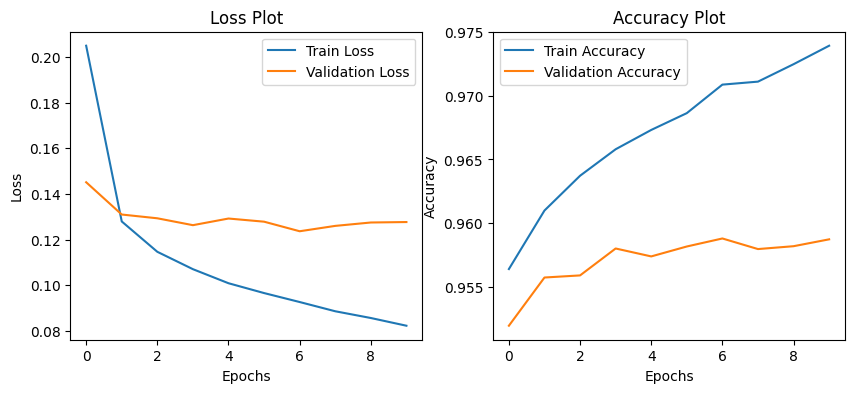

In [ ]:
# @title c7.3 [.5pt]
# Your loss plotting here: x-axis for epochs and y-axis for train and validation losses

# YOUR CODE HERE
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Plot')

# Your accuracy plotting here: x-axis for epochs and y-axis for train and validation accuracies

# YOUR CODE HERE
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Plot')

<font color="red">**Don't clear the output of the above cell!**</font>

The test accuracy on this task should be well over 90%. If you are getting an accuracy much below this, check your code carefully.

### Error analysis
<ins>Find sentences from the validation set</ins> where the network predicted wrong POS tags.  
Complete the function that returns a list of sentences where the network failed to guess a POS tag.

In [ ]:
# @title c8 [1pt]
def wrong_predictions(nn, sentences, tags, sent_vec, tag_idx, tag2idx, device=DEVICE):
    """
    :param nn: the network representing a POS tagger
    :param sentences: the list of sentences
    :param tags: a list of list of tags (aligned with sentences)
    :param sent_vec: sentences with vectorized tokens
    :param tag_idx: tags parameter where tags are mapped to indices
    :param tag2idx: mapping of tags to indices
    :param device: device for computation, defaults to the global DEVICE value
    returns a list of sentences, where sentences are a list of tuples:
        (token, tag) for correctly tagged tokens and
        (token, reference_tag, predicted_tag) for wrongly tagged tokens
    """
    # YOUR CODE HERE
    wrong_sentences = []

    nn.eval()

    for sentence, true_tags, s_vec in zip(sentences, tag_idx, sent_vec):
        s_vec = s_vec.unsqueeze(0).to(device)
        outputs = nn(s_vec)
        predicted_tags = outputs.argmax(dim=-1).squeeze()
        if len(predicted_tags.shape) == 0:
            predicted_tags = predicted_tags.unsqueeze(0)
        predicted_tags = predicted_tags.cpu().numpy()

        if not isinstance(predicted_tags, np.ndarray):
            predicted_tags = np.array([predicted_tags])
        if isinstance(true_tags, torch.Tensor):
            true_tags = true_tags.cpu().numpy()
        elif not isinstance(true_tags, np.ndarray):
            true_tags = np.array([true_tags])

        mismatches = (predicted_tags != true_tags)

        if np.any(mismatches):
            detailed_sentence = []

            tokens = sentence.split()
            for token, true_tag, pred_tag in zip(tokens, true_tags, predicted_tags):
                if true_tag != pred_tag:
                    tag_str = {v: k for k, v in tag2idx.items()}
                    detailed_sentence.append((token, tag_str[true_tag], tag_str[pred_tag]))
                else:
                    tag_str = {v: k for k, v in tag2idx.items()}
                    detailed_sentence.append((token, tag_str[true_tag]))
            wrong_sentences.append(detailed_sentence)

    return wrong_sentences

In [ ]:
wrong_preds = wrong_predictions(srn, sentences_val, postags_val, X_val, Y_val, pos_to_int)


In [ ]:
# TEST c8
for s in wrong_preds[37:42]: # feel free to change the slice indices
    print(' '.join([ t[0] if len(t) == 2 else f"{t[0]}|{t[1]}|{t[2]}" for t in s ]))

assert len(wrong_preds)/len(sentences_val) > 0.4

Still , Hugo 's impact may revive unsuccessful proposals to give local governments authority to levy sales|JJ|NNS taxes .
Residents of this city soon will be seeing ads urging them to visit Cleveland 's outdoor museum --|IN|: Lake View Cemetery .
Jaguar executives said last week they expect to have a friendly alliance with GM wrapped up|RB|RP by the end of the month .
The yield on the Treasury|NN|NNP 's benchmark 30-year bond slipped to 7.93 % .
In New York Stock Exchange composite trading , PPG closed at $ 41 a share , down|IN|RB 37.5 cents .


In [ ]:
# TEST c8
types_of_mistakes = {'Incorrect POS Tag (IN to :)': ('IN', ':'),
                     'Incorrect POS Tag (NN to NNS)': ('NN', 'NNS'),
                     'Incorrect POS Tag (RB to RP)': ('RB', 'RP')}

# Create a dictionary to store examples for each mistake type
examples = {mistake_type: [] for mistake_type in types_of_mistakes}

for s in wrong_preds:
    for t in s:
        for mistake_type, (true_tag, pred_tag) in types_of_mistakes.items():
            if len(t) == 2 and t[1] == true_tag:
                examples[mistake_type].append(f"{t[0]}|{true_tag}|{pred_tag}")
                if len(examples[mistake_type]) >= 3:
                    break
            elif len(t) == 3 and t[1] == true_tag and t[2] == pred_tag:
                examples[mistake_type].append(f"{t[0]}|{true_tag}|{pred_tag}")
                if len(examples[mistake_type]) >= 3:
                    break

    if all(len(examples[mistake_type]) >= 3 for mistake_type in types_of_mistakes):
        break

# Print examples for each mistake type
for mistake_type, example_list in examples.items():
    print(f"\n{mistake_type}:\n")
    for example in example_list:
        print(example)



Incorrect POS Tag (IN to :):

as|IN|:
on|IN|:
of|IN|:
in|IN|:
at|IN|:
of|IN|:
by|IN|:
than|IN|:
because|IN|:
of|IN|:

Incorrect POS Tag (NN to NNS):

executive|NN|NNS
approval|NN|NNS
time|NN|NNS
figure|NN|NNS
slip|NN|NNS
paper|NN|NNS
envelope|NN|NNS
traffic|NN|NNS
%|NN|NNS
yesterday|NN|NNS
afternoon|NN|NNS
airport|NN|NNS
return|NN|NNS
market|NN|NNS
investor|NN|NNS
quake|NN|NNS

Incorrect POS Tag (RB to RP):

later|RB|RP
soon|RB|RP
Meanwhile|RB|RP
down|RB|RP
n't|RB|RP


#### q8 [1pt]

Adjust the code above (in TEST cell) to make it print **three** different types of tagging mistakes you would like to discuss.  
Make suggestions as to why the mistakes were made. Refer to the [POS tags](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) for the POS tag descriptions and the [POS tag annotation guideline](https://www.cis.upenn.edu/~bies/manuals/tagguide.pdf) which defines when a particular POS tag should and should not be used.  

<font color="red">Note that we don't expect you to read the entire PDF of the guideline. Use search to find definitions of relevant POS tags and their contrast to other POS tags.

**ANSWER**: <font color="red">YOUR ANSWER HERE</font>

 **Incorrect POS Tag (NN to NNS):**
The model is consistently misclassifying singular nouns (NN) as plural nouns (NNS). This might be caused from the presence of certain suffixes or contextual factors that lead to confusion between singular and plural forms.


**Incorrect POS Tag (RB to RP):**
The model is consistently misclassifying adverbs (RB) as particles (RP). This could be caused from the model find it hard with understanding the distinction between adverbs and particles in certain contexts.


**Incorrect POS Tag (IN to :):**
The model is consistently misclassifying prepositions (IN) as colons (:). This could be caused from the ambiguity in certain contexts where a preposition might resemble a colon, leading to confusion.

### Extended error analysis

In this section we will analyze commonly confused pairs of POS tags and the reasons behind them.

Complete the function that returns details of confused pairs of POS tags. Note that the pairs are not symmetric: first one is a reference tag and another one a system-predicted tag.

<font color="red">_Hint_: In the top 5 confused pairs, there should be `JJ` occurring more than twice.  


In [ ]:
# @title c9 [.5pt]
from collections import defaultdict, Counter

def freq_confused_tags(wrongly_tagged):
    """
    :param wrongly_tagged: a list of wrongly tagged sentences. Each sentence is
        a lit of tuples (tok, tag) or (tok, ref_tag, pred_tag)
    return a pair of dictionaries (can be defaultdict):
        dict1 is {(ref_tag, pred_tag): Counter of tokens these tags were applied to in a combination}
        dict2 is {(ref_tag, pred_tag): a dictionary {token: list of all wrongly tagged sentences where the token with given tags occur}
    """
    # YOUR CODE HERE

    tag_combinations_counter = defaultdict(Counter)
    tag_combinations_sentences = defaultdict(lambda: defaultdict(list))

    for sentence in wrongly_tagged:
        for token_info in sentence:
            if len(token_info) == 3:
                token, ref_tag, pred_tag = token_info
                tag_combinations_counter[(ref_tag, pred_tag)][token] += 1
                tag_combinations_sentences[(ref_tag, pred_tag)][token].append(sentence)

    return dict(tag_combinations_counter), dict(tag_combinations_sentences)


In [ ]:
# TEST c9
confused_tags_tok_counts, confused_tags_tok_sents = freq_confused_tags(wrong_preds)
print(confused_tags_tok_sents)
assert ("RBR", "JJR") in confused_tags_tok_counts
assert isinstance(confused_tags_tok_counts[("RBR", "JJR")], Counter)
assert "more" in confused_tags_tok_counts[("RBR", "JJR")]
assert len(confused_tags_tok_sents[("RBR", "JJR")]["more"]) == confused_tags_tok_counts[("RBR", "JJR")]["more"]
assert all([ any(["more" == t[0] for t in s]) for s in confused_tags_tok_sents[("RBR", "JJR")]["more"] ])

{('RB', 'JJ'): defaultdict(<class 'list'>, {'frighteningly': [[('Five', 'CD'), ('months', 'NNS'), ('later', 'RB'), (',', ','), ('Mr.', 'NNP'), ('Tisch', 'NNP'), ('took', 'VBD'), ('over', 'RP'), ('as', 'IN'), ('CBS', 'NNP'), ("'s", 'POS'), ('chief', 'JJ'), ('executive', 'NN'), (',', ','), ('and', 'CC'), ('soon', 'RB'), ('he', 'PRP'), ('was', 'VBD'), ('wielding', 'VBG'), ('sole', 'JJ'), ('approval', 'NN'), ('each', 'DT'), ('time', 'NN'), ('Mr.', 'NNP'), ('Pilson', 'NNP'), ('scribbled', 'VBD'), ('a', 'DT'), ('frighteningly', 'RB', 'JJ'), ('large', 'JJ'), ('figure', 'NN'), ('on', 'IN'), ('a', 'DT'), ('slip', 'NN'), ('of', 'IN'), ('paper', 'NN'), (',', ','), ('sealed', 'VBD'), ('it', 'PRP'), ('in', 'IN'), ('an', 'DT'), ('envelope', 'NN'), ('and', 'CC'), ('gave', 'VBD'), ('it', 'PRP'), ('to', 'TO'), ('sports', 'NNS'), ('negotiators', 'NNS'), ('.', '.')]], 'right': [[('Mr.', 'NNP'), ('Melloan', 'NNP'), ("'s", 'POS'), ('column', 'NN'), ('was', 'VBD'), ('right', 'RB', 'JJ'), ('on', 'IN'), ('the

In [ ]:
# the code that prints top three confused tag pairs with the corresponding examples from the data
# this examples will be analyzed in your answer
# YOUR CODE HERE

top_confused_pairs = sorted(confused_tags_tok_counts.items(), key=lambda x: sum(x[1].values()), reverse=True)[:3]

# Print the top three confused tag pairs and corresponding examples
for confused_pair, token_counts in top_confused_pairs:
    print(f"\nTop Confused Tag Pair: {confused_pair}")
    print("Examples:")
    for token, count in token_counts.most_common(3):
        example_sentences = confused_tags_tok_sents[confused_pair][token][:3]
        print(f"{token}: {count} occurrences")
        for example_sentence in example_sentences:
            print(f"\t- {' '.join([t[0] for t in example_sentence])}")

# Ensure the output is printed for analysis
assert top_confused_pairs


Top Confused Tag Pair: ('NN', 'JJ')
Examples:
chief: 33 occurrences
	- Those allies included Politburo members Guenter Mittag , who has long headed economic affairs , and Joachim Hermann , chief of information policy .
	- V.H. Van Horn , National Convenience president and chief executive officer , said the move reflects the company 's realization that the industry 's poor performance stems from its failure to give customers what they want -- rather than from increasing competition from gasoline stations and 24-hour grocery stores .
	- Succeeding him as chairman and chief executive will be Frank Lorenzo , chairman and chief executive of Continental 's parent , Texas Air Corp .
many: 25 occurrences
	- The Wall Street Journal 's American Way of Buying survey this year found that most consumers switch brands for many of the products they use .
	- The new instrument also introduced many to the industry -- 30 % of fund owners -LRB- there are more than 54 million accounts -RRB- started with 

#### q9 [1pt]

What are the top **three** commonly confused pairs of POS tags?  
For each pair, make suggestions as to why these tag pairs are frequently confused. Refer to the examples above printed by your code.

**ANSWER**: <font color="red">YOUR ANSWER HERE</font>


**1. ('NN', 'JJ') - Noun to Adjective**

Examples:

**chief**: The model often confuses nouns (NN) with adjectives (JJ). In the examples seen above, "chief" is misclassified as an adjective This confusion may come from the fact that "chief" can be used as both a noun and an adjective in different cases

**many**: Similar to "chief," the model confuses "many" as an adjective when it should be tagged as a noun. This confusion might be happening from the context where "many" is used to describe a quantity, leading to the model misinterpreting it as an adjective.

**public**: The model misclassifies "public" aswell. This confusion may be due to similar reasons as the examplea above.

**2. ('JJ', 'NN') - Adjective to Noun**

Examples:

**executive**: The model frequently confuses adjectives (JJ) with nouns (NN). In the examples, "executive" is misclassified as an adjective when it should be tagged as a noun. This error might occur because "executive" is commonly used as a noun in business contexts.

**net**: The model misclassifies "net" as an adjective when it should be tagged as a noun. This confusion may arise from the context where "net" refers to a financial term, leading to the model incorrectly tagging it as an adjective.

**Net**: Similar to the lowercase "net," the model confuses the uppercase "Net" as an adjective instead of a noun. This could be due to inconsistency in case sensitivity.

**3. ('RB', 'IN') - Adverb to Preposition**

Examples:

**as**: The model frequently misclassifies adverbs (RB) as prepositions (IN). In the examples, "as" is misclassified as a preposition when it should be tagged as an adverb. This error may occur due to the diverse roles of "as" in different contexts.

**about**:  This confusion may arise from the varied uses of "about" in different contexts similarly to "as".

**on**: This error could result from the diverse roles of "on" in different sentence structures.

### Congratulations!
🎉 You are done with the required part!

### Optional

RNNs have limited expressive capacity that can be surpassed by more complicated variants such as [Gated Recurrent Units](https://en.wikipedia.org/wiki/Gated_recurrent_unit) and [Long Short-Term Memory Units](https://en.wikipedia.org/wiki/Long_short-term_memory); replacing your RNN with those could easily improve the performance.

If you found the previous part easy and are already done, you can use other neural architectures to do the same task on the same dataset and compare their performance.  (There will be no support provided for this, or points, but you are welcome to explore this for your own understanding :))

Whatever your design choices are, keep the torch documentation close at all times! Do not reinvent the wheel, use existing abstractions whenever possible (but make sure you use them the right way!). Take measures against overfitting: regularize with dropout and/or weight decay and keep track of the validation set performance to stop training early if needed.

# Acknowledgment

The jupyter notebook was initially created by Konstantinos Kogkalidis and Tejaswini Deoskar.  
Recent changes, including adaptation to the Colab environment and formulation of several coding tasks in terms of functions, are by Lasha Abzianidze.